# bellatrixバージョンでのARPの計算
bellatrix(The Merge時のBeaconchainのバージョン名）ではbase_rewardの計算式が変わってるので、それをもとにインフレ率を計算してみるた。

|Name | Value |
|---  |---    |
|TIMELY_SOURCE_WEIGHT|uint64(14)|
|TIMELY_TARGET_WEIGHT|uint64(26)|
|TIMELY_HEAD_WEIGHT  |uint64(14)|
|SYNC_REWARD_WEIGHT  |uint64(2) |
|PROPOSER_WEIGHT     |uint64(8) |
|WEIGHT_DENOMINATOR  |uint64(64)|


## 変更されたbase_rewardの計算式
https://github.com/ethereum/consensus-specs/blob/dev/specs/altair/beacon-chain.md#get_base_reward_per_increment


#### get_base_reward_per_increment

```python
def get_base_reward_per_increment(state: BeaconState) -> Gwei:
    return Gwei(EFFECTIVE_BALANCE_INCREMENT * BASE_REWARD_FACTOR // integer_squareroot(get_total_active_balance(state)))
```


#### get_base_reward

Note: The function get_base_reward is modified with the removal of BASE_REWARDS_PER_EPOCH and the use of increment based accounting.

Note: On average an optimally performing validator earns one base reward per epoch.

```python
def get_base_reward(state: BeaconState, index: ValidatorIndex) -> Gwei:
    """
    Return the base reward for the validator defined by ``index`` with respect to the current ``state``.
    """
    increments = state.validators[index].effective_balance // EFFECTIVE_BALANCE_INCREMENT
    return Gwei(increments * get_base_reward_per_increment(state))
```

epoc_per_year: 82125.0, deposited: 99200000000000000
reward_per_epoch: 1144640000, reward_per_year: 94003560000000.0, arp: 0.0009476165322580645
base:114464, prop:30077500.0


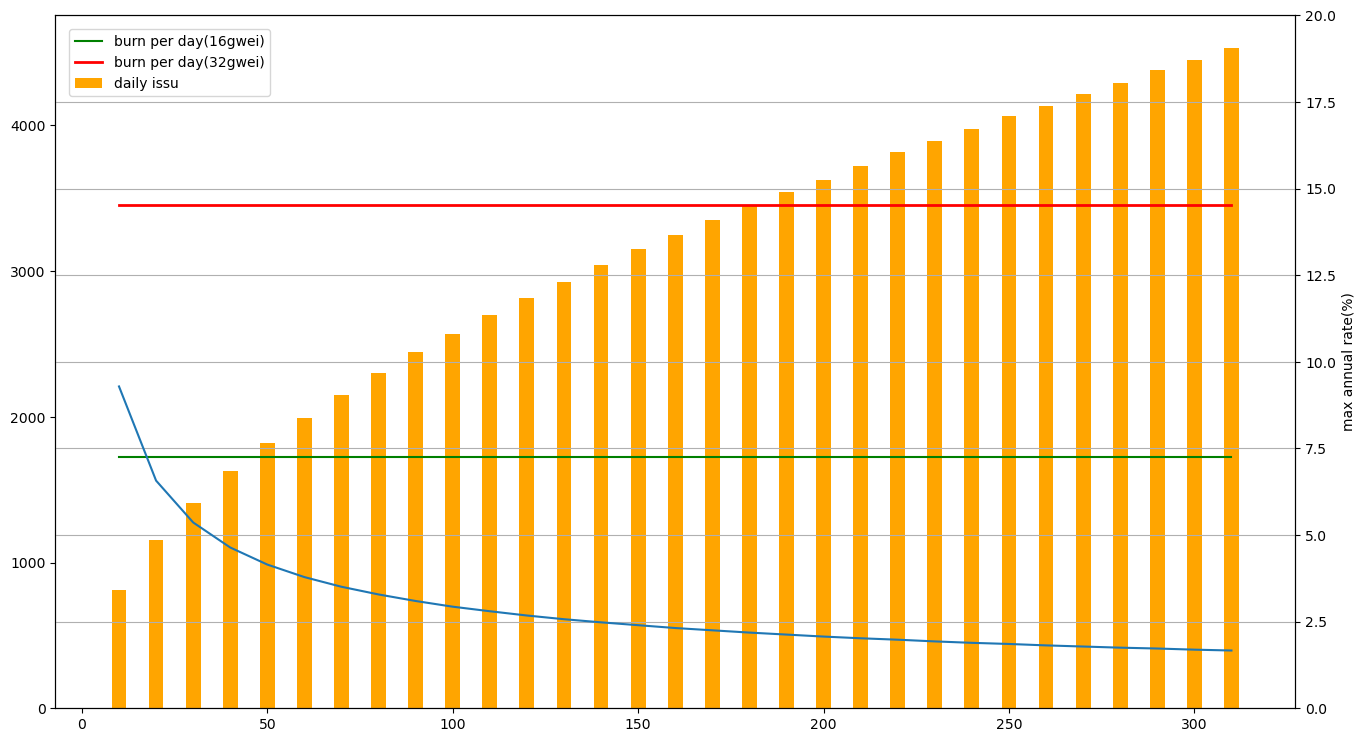

In [171]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

EFFECTIVE_BALANCE_INCREMENT = 10**9
BASE_REWARD_FACTOR = 64
MAX_EFFECTIVE_BALANCE = 32 * 10**9 # 32ETH (unit GWei)
MAX_BLOCK_GAS_LIMIT = 30 * 10 ** 6 # 30M gas

def get_base_reward_per_increment(validator_count):
    total_balance = validator_count * MAX_EFFECTIVE_BALANCE
    intsqrt = int(np.sqrt(total_balance))
    return EFFECTIVE_BALANCE_INCREMENT * BASE_REWARD_FACTOR // intsqrt

def get_base_reward(validator_count):
    increments = MAX_EFFECTIVE_BALANCE // EFFECTIVE_BALANCE_INCREMENT
    return increments * get_base_reward_per_increment(validator_count)

def get_burn_per_day(base_fee):
    burn_fee_16gwei_base = base_fee * MAX_BLOCK_GAS_LIMIT / 2 # half is average gas used
    return burn_fee_16gwei_base * 60 * 60 * 24 / 12

validator_count = 10000
base_reward = get_base_reward(validator_count)
sec_per_epoch = 32 * 12
epoc_per_year = 60 * 60 * 24 * 365 / sec_per_epoch


reward_per_epoch = base_reward * validator_count
reward_per_year = reward_per_epoch * epoc_per_year
print(f'epoc_per_year: {epoc_per_year}, deposited: {deposited}')
print(f'reward_per_epoch: {reward_per_epoch}, reward_per_year: {reward_per_year}, arp: {reward_per_year / deposited}')
print(f'base:{base_reward}, prop:{reward_propose}')

base_fee_per_gas = 16 # 16GWei

df = pd.DataFrame()
for validator_count in range(100000, 3200000, 100000):
    deposited = MAX_EFFECTIVE_BALANCE * validator_count
    base_reward = get_base_reward(validator_count)
    reward_per_epoch = base_reward * validator_count
    reward_per_year = reward_per_epoch * epoc_per_year
    arp = reward_per_year / deposited
    
    df = pd.concat([df, pd.DataFrame(
        {
            'validators': validator_count  / 10000,
            'arp':arp * 100, 
            'total_depo': deposited // EFFECTIVE_BALANCE_INCREMENT,
            'mai': reward_per_year // EFFECTIVE_BALANCE_INCREMENT,
            'daily': reward_per_year / 365 // EFFECTIVE_BALANCE_INCREMENT,
            'burn_16': get_burn_per_day(16) // EFFECTIVE_BALANCE_INCREMENT,
            'burn_32': get_burn_per_day(32) // EFFECTIVE_BALANCE_INCREMENT
        }
        , index=[len(df)])
                   ])


fig, ax = plt.subplots(1,1,figsize=(16,9))
ax2 = ax.twinx()

index = df['validators']
ax.bar(index, df['daily'], label='daily issu', color="orange", width=4.0)
ax.plot(index, df['burn_16'], label='burn per day(16gwei)', color="green")
ax.plot(index, df['burn_32'], label='burn per day(32gwei)', color="red", lw=2.0)

ax2.plot(index, df['arp'], label='max annual rate')
ax2.set_ylim((0,20))
ax2.set_ylabel('max annual rate(%)')
ax2.grid(True)

# labelを設定
handler1, label1 = ax.get_legend_handles_labels()
ax.legend(handler1,label1,borderaxespad=1)
# ax.right_ax.set_ylim([0,20])
# ax.right_ax.set_ylabel('max annual rate(%)')
fig.savefig("eth_annu_rate.png")